In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6201 sha256=933b83ecec1b05aa14d3b9ea9b5231f7ae88b7dd8ac8d6f662874d4664268337
  Stored in directory: /root/.cache/pip/wheels/5d/c0/1d/a539c1c2a4d41c5d7109899289cded24fe1320b6a6c7b02a4c
Successfully built torch-utils


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
from torchvision import transforms
from torchvision import datasets
from torchvision import models
import torchvision
from torch import optim, cuda, Tensor
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf

from sklearn.model_selection import train_test_split
import os
import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np

import os
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
control_files = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/FinalProject/data/control/photos/*.jpg")
patient_files = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/FinalProject/data/patient/photos/*.jpg")
control_files = control_files
patient_files = patient_files
control_img = []
for img_name in control_files:
    img = Image.open(img_name)
    control_img.append(np.array(img))
control_label = [0] * len(control_img)
    
patient_img = []
for img_name in patient_files:
    img = Image.open(img_name)
    patient_img.append(np.array(img))
patient_label = [1] * len(patient_img)

Text(0.5, 1.0, 'Patient')

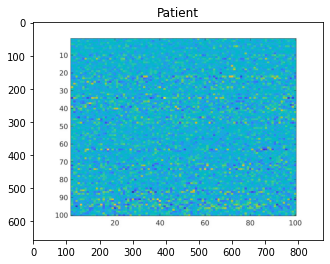

Text(0.5, 1.0, 'Control')

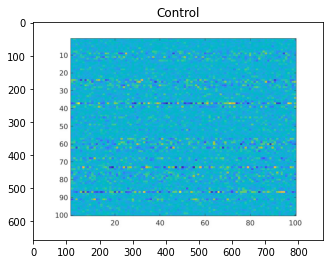

In [ ]:
plt.imshow(patient_img[np.random.randint(len(patient_img))])
plt.title("Patient")
plt.show()

plt.imshow(control_img[np.random.randint(len(control_img))])
plt.title("Control")
plt.show()

In [ ]:
train_x = np.squeeze(np.array((control_img + patient_img)))
train_y = np.asarray(control_label + patient_label)
print(train_x.shape,train_y.shape)

(516, 656, 875, 3) (516,)


In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2)
train_x = train_x.reshape(len(train_x), 3, 656, 875)
val_x = val_x.reshape(len(val_x), 3, 656, 875)

In [ ]:
# Datasets organization
batch_size = 10

# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y).float()),
    'valid':
    TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y).float())
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=1),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True, num_workers=1)       
}

In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
       

        # Set to training
  
        model.train()
        
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            
            # Tensors to gpu
            
            if train_on_gpu:
                model = model.cuda()
                data, target = data.cuda(), target.cuda()
           

            # Clear gradients
            optimizer.zero_grad()

            # Get your output from your model
          
            model = model.float()
            output = model(data.float())

            # Loss and backpropagation of gradients
            
            loss = criterion(output, target.long())
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            


            # Calculate accuracy by finding max log probability
            
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
           

            # Need to convert correct tensor from int to float to average
            
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            

            # Multiply average accuracy times the number of examples in batch
            
            train_acc += accuracy.item() * data.size(0)
            

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                
                model.eval()
                

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    
                    if train_on_gpu:
                        model = model.cuda()
                        data, target = data.cuda(), target.cuda()
                    
                    # Forward pass                    
                    model = model.float()
                    output = model(data.float())
                    
                    # Validation loss
                    loss = criterion(output, target.long())
                    
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)
                    
                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)
                

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)
                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict                        
                        model.load_state_dict(torch.load(save_file_name))
                        
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [ ]:
model = torchvision.models.resnet50(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
                            nn.Dropout(),
                            nn.Linear(num_ftrs, 150),
                            nn.ReLU(),
                            nn.Linear(150, 64),
                            nn.ReLU(),
                            nn.Linear(64, 16),
                            nn.ReLU(),
                            nn.Linear(16,2),
                            nn.LogSoftmax(dim=1))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = .01)

from timeit import default_timer as timer
save_file_name = f'resnet-50_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=10,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.7888 	Validation Loss: 0.6594
		Training Accuracy: 60.92%	 Validation Accuracy: 63.46%

Epoch: 1 	Training Loss: 0.6669 	Validation Loss: 0.6666
		Training Accuracy: 64.08%	 Validation Accuracy: 63.46%

Epoch: 2 	Training Loss: 0.6649 	Validation Loss: 0.6597
		Training Accuracy: 64.08%	 Validation Accuracy: 63.46%

Epoch: 3 	Training Loss: 0.6561 	Validation Loss: 0.6564
		Training Accuracy: 64.08%	 Validation Accuracy: 63.46%

Epoch: 4 	Training Loss: 0.6557 	Validation Loss: 0.6573
		Training Accuracy: 64.08%	 Validation Accuracy: 63.46%

Epoch: 5 	Training Loss: 0.6533 	Validation Loss: 0.6579
		Training Accuracy: 64.08%	 Validation Accuracy: 63.46%

Epoch: 6 	Training Loss: 0.6536 	Validation Loss: 0.6568
		Training Accuracy: 64.08%	 Validation Accuracy: 63.46%

Epoch: 7 	Training Loss: 0.6538 	Validation Loss: 0.6563
		Training Accuracy: 64.08%	 Validation Accuracy: 63.46%

Epoch: 8 	Training Loss: 0.6532 	Validation Lo